<a href="https://colab.research.google.com/github/Kapiushon07/Image-Reconstruction-and-In-Painting/blob/main/Image_Reconstruction_and_In_painting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


==================== PROCESSING CASE: BLOCK ====================
Removed block region: (172:202, 47:77)

--- Running Gradient Descent (GD)... ---
GD Results: Time=24.69s, RMSE=0.118855, PSNR=18.50 dB

--- Running Alternating Least Squares (ALS)... ---
ALS Results: Time=14.79s, RMSE=0.309452, PSNR=10.19 dB

==================== PROCESSING CASE: RANDOM ====================
Removed 900 random pixels.

--- Running Gradient Descent (GD)... ---
GD Results: Time=18.65s, RMSE=0.058205, PSNR=24.70 dB

--- Running Alternating Least Squares (ALS)... ---
ALS Results: Time=12.91s, RMSE=0.059477, PSNR=24.51 dB


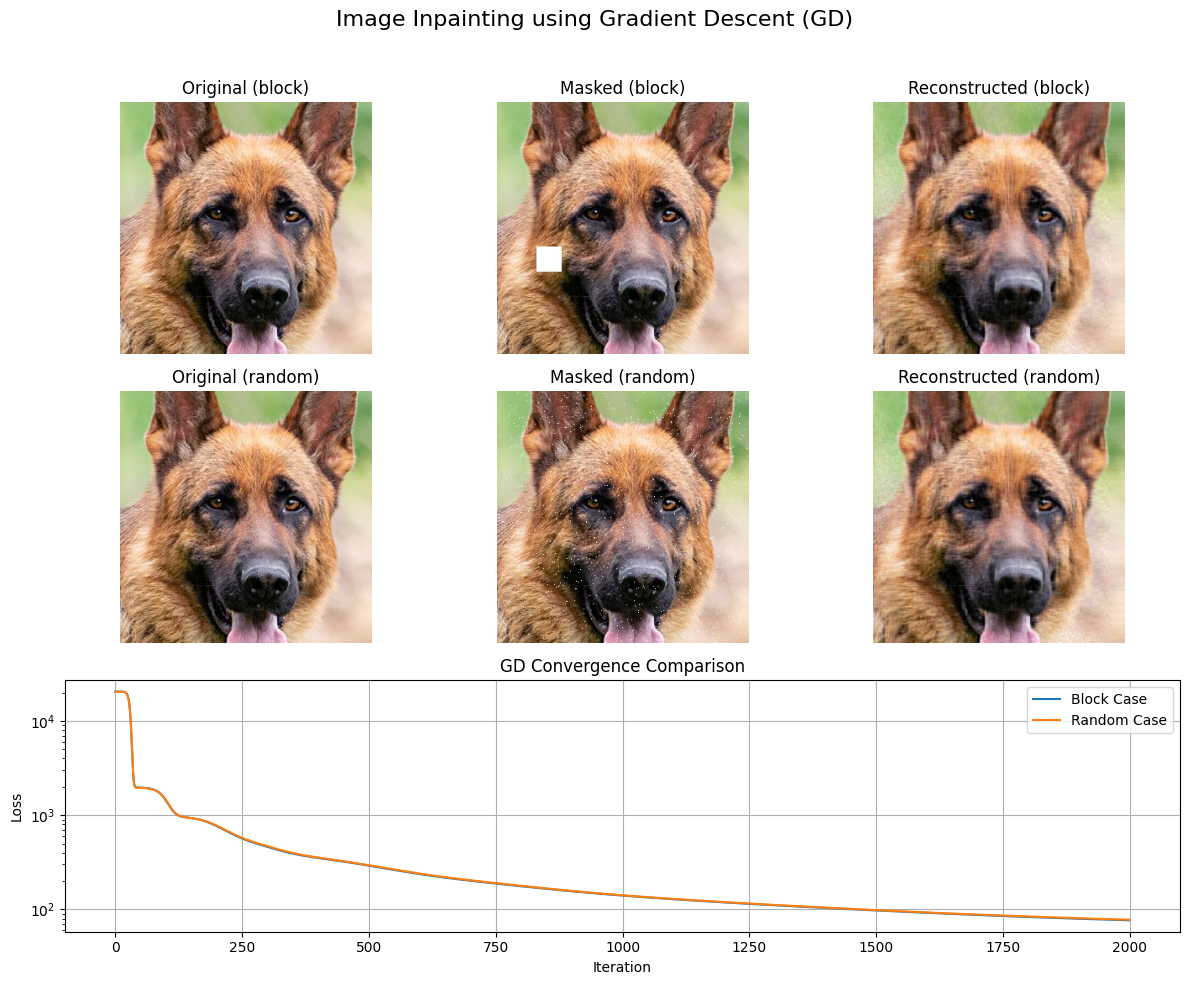

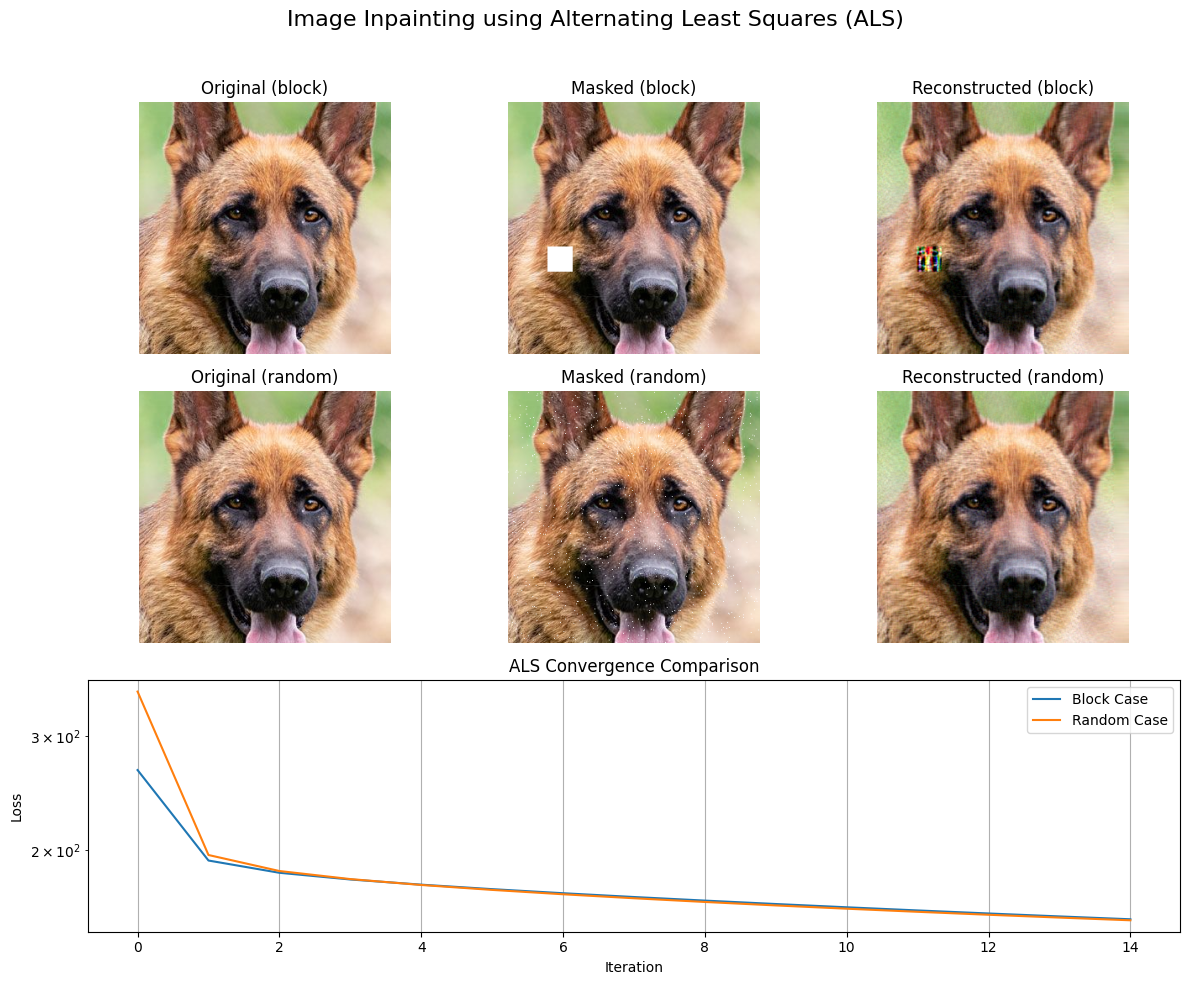

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import requests
from io import BytesIO
from time import time
import torch

def load_and_crop_image(image_path, crop_params):
    top, left, height, width = crop_params

    if image_path.startswith("http"):
        response = requests.get(image_path)
        if not response.ok:
            raise IOError(f"Failed to download image. Status code: {response.status_code}")
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img = Image.open(image_path).convert("RGB")

    img = np.array(img)[top:top + height, left:left + width]
    img = img.astype(np.float32) / 255.0
    return img

def mask_image(img, case='block', block_size=30, seed=0):
    masked_img = img.copy()
    mask = np.ones_like(img, dtype=np.float32)

    h, w, c = img.shape
    rng = np.random.RandomState(seed) # Use a seed for reproducibility

    if case == 'block':
        if block_size >= h or block_size >= w:
            print("Warning: block_size too large, skipping masking.")
            return masked_img, mask
        start_row = rng.randint(0, h - block_size + 1)
        start_col = rng.randint(0, w - block_size + 1)
        masked_img[start_row:start_row + block_size, start_col:start_col + block_size, :] = 1
        mask[start_row:start_row + block_size, start_col:start_col + block_size, :] = 0
        print(f"Removed block region: ({start_row}:{start_row+block_size}, {start_col}:{start_col+block_size})")

    elif case == 'random':
        num_pixels_to_remove = min(block_size * block_size, h * w)
        rows = rng.randint(0, h, size=num_pixels_to_remove)
        cols = rng.randint(0, w, size=num_pixels_to_remove)
        masked_img[rows, cols, :] = 1
        mask[rows, cols, :] = 0
        print(f"Removed {num_pixels_to_remove} random pixels.")

    return masked_img, mask


# Matrix Factorization Method 1: Gradient Descent (GD)
def matrix_factorization_gd(observed_matrix, mask, rank=30, lr=0.001, reg=1e-3,
                                  max_iter=2000, tol=1e-6, verbose=False, clip_grad=1e2):
    M = observed_matrix
    m, n = M.shape
    rng = np.random.RandomState(0)
    U = 0.01 * rng.randn(m, rank)
    V = 0.01 * rng.randn(n, rank)

    losses = []
    prev_loss = None
    t0 = time()
    for it in range(1, max_iter + 1):
        recon = U @ V.T
        residual = (recon - M) * mask
        loss = 0.5 * np.sum(residual**2) + 0.5 * reg * (np.sum(U**2) + np.sum(V**2))
        losses.append(loss)
        if prev_loss is not None and abs(prev_loss - loss) < tol:
            if verbose: print(f"Converged at iteration {it}")
            break
        prev_loss = loss
        grad_U = residual @ V + reg * U
        grad_V = residual.T @ U + reg * V
        grad_U = np.clip(grad_U, -clip_grad, clip_grad)
        grad_V = np.clip(grad_V, -clip_grad, clip_grad)
        U -= lr * grad_U
        V -= lr * grad_V
    total_time = time() - t0
    recon = np.clip(U @ V.T, 0, 1)
    return recon, total_time, losses


# Matrix Factorization Method 2: Alternating Least Squares (ALS)
def matrix_factorization_als(observed_matrix, mask, rank=30, reg=1e-3, n_iter=15, tol=1e-6, verbose=False):
    X = torch.tensor(observed_matrix, dtype=torch.float32)
    M = torch.tensor(mask, dtype=torch.bool)
    m, n = X.shape
    torch.manual_seed(0)
    U = torch.randn((m, rank), dtype=torch.float32) * 0.01
    V = torch.randn((n, rank), dtype=torch.float32) * 0.01
    losses = []
    t0 = time()
    for it in range(1, n_iter + 1):
        for i in range(m):
            idx = M[i, :].nonzero(as_tuple=True)[0]
            if len(idx) == 0: continue
            V_i, X_i = V[idx, :], X[i, idx]
            A = V_i.T @ V_i + reg * torch.eye(rank)
            b = V_i.T @ X_i
            U[i, :] = torch.linalg.lstsq(A, b.unsqueeze(1)).solution.squeeze()
        for j in range(n):
            idx = M[:, j].nonzero(as_tuple=True)[0]
            if len(idx) == 0: continue
            U_j, X_j = U[idx, :], X[idx, j]
            A = U_j.T @ U_j + reg * torch.eye(rank)
            b = U_j.T @ X_j
            V[j, :] = torch.linalg.lstsq(A, b.unsqueeze(1)).solution.squeeze()
        recon_tensor = U @ V.T
        diff = X[M] - recon_tensor[M]
        loss = 0.5 * torch.sum(diff**2) + 0.5 * reg * (torch.sum(U**2) + torch.sum(V**2))
        losses.append(loss.item())
    total_time = time() - t0
    recon = torch.clamp(recon_tensor, 0, 1)
    return recon.numpy(), total_time, losses


def compute_metrics(original, reconstructed, mask):
    missing_mask = (1 - mask).astype(bool)
    y_true, y_pred = original[missing_mask], reconstructed[missing_mask]
    if y_true.size == 0: return 0, float('inf')
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = math.sqrt(mse)
    psnr = float('inf') if mse == 0 else 20 * math.log10(1.0 / math.sqrt(mse))
    return rmse, psnr


# Main
def image_reconstruction_comparison(image_path, crop_params, r):
    img = load_and_crop_image(image_path, crop_params)
    cases = ['block', 'random']
    h, w, c = img.shape

    # Data Storage
    results = {}

    for case in cases:
        print("\n" + "="*20 + f" PROCESSING CASE: {case.upper()} " + "="*20)
        # Use a different seed for mask generation in each case for variety
        seed = 0 if case == 'block' else 1
        masked_img, mask = mask_image(img, case=case, block_size=30, seed=seed)

        # Run Gradient Descent ---
        print("\n--- Running Gradient Descent (GD)... ---")
        recon_gd, total_time_gd, losses_gd = [np.zeros_like(img), 0, []]
        for ch in range(c):
            M_ch, mask_ch = masked_img[..., ch], mask[..., ch]
            R_ch, time_ch, l_gd = matrix_factorization_gd(M_ch, mask_ch, rank=r)
            recon_gd[..., ch], total_time_gd = R_ch, total_time_gd + time_ch
            if ch == 0: losses_gd = l_gd
        rmse_gd, psnr_gd = compute_metrics(img, recon_gd, mask)
        print(f"GD Results: Time={total_time_gd:.2f}s, RMSE={rmse_gd:.6f}, PSNR={psnr_gd:.2f} dB")

        # Run Alternating Least Squares ---
        print("\n--- Running Alternating Least Squares (ALS)... ---")
        recon_als, total_time_als, losses_als = [np.zeros_like(img), 0, []]
        for ch in range(c):
            M_ch, mask_ch = masked_img[..., ch], mask[..., ch]
            R_ch, time_ch, l_als = matrix_factorization_als(M_ch, mask_ch, rank=r)
            recon_als[..., ch], total_time_als = R_ch, total_time_als + time_ch
            if ch == 0: losses_als = l_als
        rmse_als, psnr_als = compute_metrics(img, recon_als, mask)
        print(f"ALS Results: Time={total_time_als:.2f}s, RMSE={rmse_als:.6f}, PSNR={psnr_als:.2f} dB")

        # results
        results[case] = {
            "masked": masked_img, "gd_recon": recon_gd, "als_recon": recon_als,
            "gd_losses": losses_gd, "als_losses": losses_als
        }

    # Plot 1: Gradient Descent Results
    fig_gd = plt.figure(figsize=(12, 10))
    fig_gd.suptitle('Image Inpainting using Gradient Descent (GD)', fontsize=16)
    gs_gd = fig_gd.add_gridspec(3, 3)

    # GD Image rows
    for i, case in enumerate(cases):
        ax1 = fig_gd.add_subplot(gs_gd[i, 0]); ax1.imshow(img); ax1.set_title(f'Original ({case})'); ax1.axis('off')
        ax2 = fig_gd.add_subplot(gs_gd[i, 1]); ax2.imshow(results[case]['masked']); ax2.set_title(f'Masked ({case})'); ax2.axis('off')
        ax3 = fig_gd.add_subplot(gs_gd[i, 2]); ax3.imshow(results[case]['gd_recon']); ax3.set_title(f'Reconstructed ({case})'); ax3.axis('off')

    # GD Convergence plot spanning the bottom row
    ax_conv_gd = fig_gd.add_subplot(gs_gd[2, :])
    ax_conv_gd.plot(results['block']['gd_losses'], label='Block Case')
    ax_conv_gd.plot(results['random']['gd_losses'], label='Random Case')
    ax_conv_gd.set_title('GD Convergence Comparison'); ax_conv_gd.set_xlabel('Iteration'); ax_conv_gd.set_ylabel('Loss')
    ax_conv_gd.grid(True); ax_conv_gd.set_yscale('log'); ax_conv_gd.legend()
    fig_gd.tight_layout(rect=[0, 0, 1, 0.96])

    # Plot 2: Alternating Least Squares Results
    fig_als = plt.figure(figsize=(12, 10))
    fig_als.suptitle('Image Inpainting using Alternating Least Squares (ALS)', fontsize=16)
    gs_als = fig_als.add_gridspec(3, 3)

    # ALS Image rows
    for i, case in enumerate(cases):
        ax1 = fig_als.add_subplot(gs_als[i, 0]); ax1.imshow(img); ax1.set_title(f'Original ({case})'); ax1.axis('off')
        ax2 = fig_als.add_subplot(gs_als[i, 1]); ax2.imshow(results[case]['masked']); ax2.set_title(f'Masked ({case})'); ax2.axis('off')
        ax3 = fig_als.add_subplot(gs_als[i, 2]); ax3.imshow(results[case]['als_recon']); ax3.set_title(f'Reconstructed ({case})'); ax3.axis('off')

    # ALS Convergence plot spanning the bottom row
    ax_conv_als = fig_als.add_subplot(gs_als[2, :])
    ax_conv_als.plot(results['block']['als_losses'], label='Block Case')
    ax_conv_als.plot(results['random']['als_losses'], label='Random Case')
    ax_conv_als.set_title('ALS Convergence Comparison'); ax_conv_als.set_xlabel('Iteration'); ax_conv_als.set_ylabel('Loss')
    ax_conv_als.grid(True); ax_conv_als.set_yscale('log'); ax_conv_als.legend()
    fig_als.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()

# execution
image_path = "https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg"
crop_params = (150, 1050, 300, 300)
r = 50
image_reconstruction_comparison(image_path, crop_params, r)




==================== PROCESSING CASE: Patch 1 at (150, 100) ====================
  Rank r=5: RMSE = 0.0605
  Rank r=10: RMSE = 0.0426
  Rank r=25: RMSE = 0.0193
  Rank r=50: RMSE = 0.0117

==================== PROCESSING CASE: Patch 2 at (50, 150) ====================
  Rank r=5: RMSE = 0.0401
  Rank r=10: RMSE = 0.0289
  Rank r=25: RMSE = 0.0170
  Rank r=50: RMSE = 0.0121

==================== PROCESSING CASE: Patch 3 at (100, 50) ====================
  Rank r=5: RMSE = 0.0760
  Rank r=10: RMSE = 0.0570
  Rank r=25: RMSE = 0.0240
  Rank r=50: RMSE = 0.0116


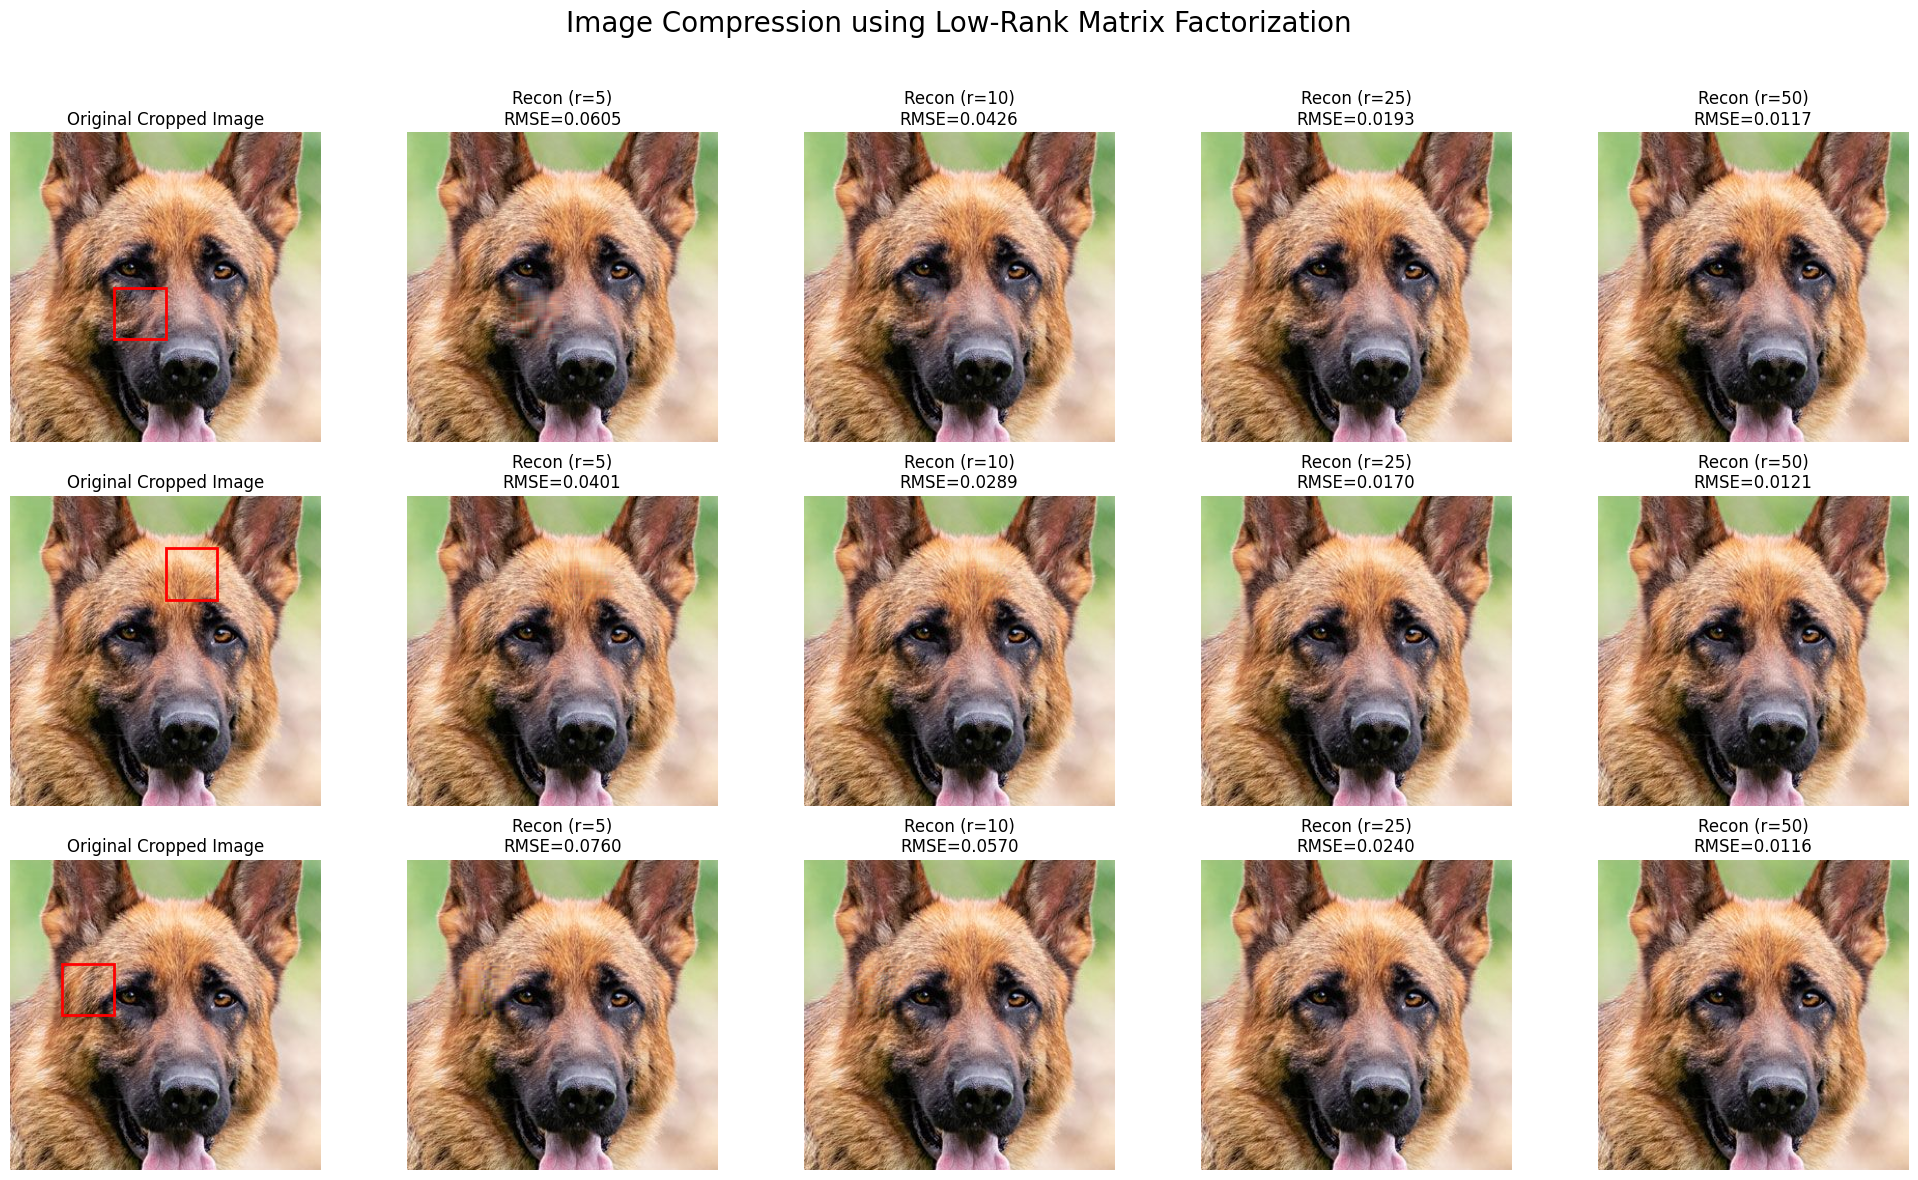

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import requests
from io import BytesIO
from time import time

def load_image(image_path):
    if image_path.startswith("http"):
        response = requests.get(image_path)
        if not response.ok:
            raise IOError(f"Failed to download image. Status code: {response.status_code}")
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        img = Image.open(image_path).convert("RGB")

    # Normalize to [0,1]
    img = np.array(img).astype(np.float32) / 255.0
    return img

def compute_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed)**2))


# Matrix Factorization for Compression using Gradient Descent
def matrix_factorization_gd(matrix, rank, max_iter=2000, lr=0.005, reg=1e-4, seed=0):

    m, n = matrix.shape
    rng = np.random.RandomState(seed)
    U = 0.01 * rng.randn(m, rank)
    V = 0.01 * rng.randn(n, rank)

    for it in range(max_iter):
        recon = U @ V.T
        residual = recon - matrix

        # Gradients
        grad_U = residual @ V + reg * U
        grad_V = residual.T @ U + reg * V

        # Update
        U -= lr * grad_U
        V -= lr * grad_V

    # Return the final reconstructed matrix
    return np.clip(U @ V.T, 0, 1)


# Main
def image_compression_analysis(image_path):
    # create the cropped image for analysis
    full_img = load_image(image_path)
    crop_params = (150, 1050, 300, 300)
    top_crop, left_crop, height, width = crop_params
    img = full_img[top_crop:top_crop + height, left_crop:left_crop + width]

    patch_size = 50
    patch_list = [
        [150, 100],  # (Fur on side)
        [50, 150],   # (Edge of black/brown fur)p
        [100, 50]    # (Textured fur)
    ]

    ranks = [5, 10, 25, 50]

    fig, axes = plt.subplots(len(patch_list), len(ranks) + 1, figsize=(20, 12))
    fig.suptitle('Image Compression using Low-Rank Matrix Factorization', fontsize=20)

    for i, patch_coords in enumerate(patch_list):
        top_patch, left_patch = patch_coords
        size = patch_size
        case_name = f"Patch {i+1} at ({top_patch}, {left_patch})"

        print("\n" + "="*20 + f" PROCESSING CASE: {case_name} " + "="*20)


        original_patch = img[top_patch:top_patch+size, left_patch:left_patch+size, :]

        # Display the CROPPED image in the first column and draw a red box arounnd patch
        ax = axes[i, 0]
        ax.imshow(img)
        ax.set_title("Original Cropped Image")
        rect = plt.Rectangle((left_patch, top_patch), size, size, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.axis('off')

        for j, r in enumerate(ranks):
            reconstructed_patch = np.zeros_like(original_patch)

            for channel in range(img.shape[2]):
                matrix_channel = original_patch[:, :, channel]
                recon_channel = matrix_factorization_gd(matrix_channel, rank=r)
                reconstructed_patch[:, :, channel] = recon_channel

            rmse = compute_rmse(original_patch, reconstructed_patch)
            print(f"  Rank r={r}: RMSE = {rmse:.4f}")

            # Create a copy of the cropped image and replace the patch area
            reconstructed_image = img.copy()
            reconstructed_image[top_patch:top_patch+size, left_patch:left_patch+size, :] = reconstructed_patch

            ax = axes[i, j + 1]
            ax.imshow(reconstructed_image)
            ax.set_title(f"Recon (r={r})\nRMSE={rmse:.4f}")
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# execution
image_path = "https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg"
image_compression_analysis(image_path)

